In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geojson
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from descartes import PolygonPatch
from haversine import haversine

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans

%matplotlib inline

In [2]:
train = pd.read_csv("D:/BBDD/TAXI_NYC/train.csv")
test = pd.read_csv("D:/BBDD/TAXI_NYC/test.csv")

In [3]:
id_train = train.id
id_test = test.id

train.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)

In [4]:
print(train.shape)
print(test.shape)

(1458644, 10)
(625134, 8)


In [5]:
#train.head()

In [6]:
train['pickup_datetime']  = pd.to_datetime(train['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

In [7]:
test['pickup_datetime']  = pd.to_datetime(test['pickup_datetime'])



In [8]:
train.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


#### Voy a usar fuentes externas de informacion, como los dias de festivos en el año 2016 en NY y la climatologia de ese año.

In [9]:
hf = pd.read_csv("D:/BBDD/TAXI_NYC/NYC_2016Holidays.csv", sep=';')
hf['Date']  = pd.to_datetime(hf['Date'])
#hf

In [10]:
wf = pd.read_csv('D:/BBDD/TAXI_NYC/weather_NY_2016.csv')
wf['date']  = pd.to_datetime(wf['date'])

#wf.head()

In [11]:
coords = np.vstack((train[['pickup_latitude',  'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    train[['pickup_latitude',  'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords)

In [12]:
def derive_features(train):
    train = train.copy()
    # Pickup-based features
    train['pickup_date'] = train['pickup_datetime'].dt.date
    train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
    train['pickup_hour'] = train['pickup_datetime'].dt.hour
    train['pickup_month'] = train['pickup_datetime'].dt.month
    train['pickup_day'] = train['pickup_datetime'].dt.day
    # Brand new features
    train['haversine_distance'] = train.apply(lambda x: haversine((x['pickup_latitude'],  x['pickup_longitude']), 
                                                            (x['dropoff_latitude'], x['dropoff_longitude'])), axis=1)
    #train['pickup_cluster']  = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
    #train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
    return train

In [13]:
train = derive_features(train)

In [14]:
def derive_features_test(test):
    test = test.copy()
    # Pickup-based features
    test['pickup_date'] = test['pickup_datetime'].dt.date
    test['pickup_weekday'] = test['pickup_datetime'].dt.weekday
    test['pickup_hour'] = test['pickup_datetime'].dt.hour
    test['pickup_month'] = test['pickup_datetime'].dt.month
    test['pickup_day'] = test['pickup_datetime'].dt.day
    # Brand new features
    test['haversine_distance'] = test.apply(lambda x: haversine((x['pickup_latitude'],  x['pickup_longitude']), 
                                                            (x['dropoff_latitude'], x['dropoff_longitude'])), axis=1)
    #test['pickup_cluster']  = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
    #test['dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])
    return test

In [15]:
test = derive_features_test(test)

In [16]:
def clean_data(train):
    train = train.copy()
    train = train[(train['trip_duration'] > 60) & (train['trip_duration'] < 3600 * 24)] # Trip duration filtering
    train = train[(train['haversine_distance'] > 0.01)] # Distance filtering
    return train

In [17]:
train = clean_data(train)

In [18]:
def clean_data_test(test):
    test = test.copy()
    #test = test[(test['trip_duration'] > 60) & (test['trip_duration'] < 3600 * 24)] # Trip duration filtering
    test = test[(test['haversine_distance'] > 0.01)] # Distance filtering
    return test

In [19]:
test = clean_data_test(test)

In [20]:
wf = wf.replace(to_replace='T', value=0.01)

wf['precipitation'] = pd.to_numeric(wf['precipitation'])
wf['snow fall'] = pd.to_numeric(wf['snow fall'])
wf['snow depth'] = pd.to_numeric(wf['snow depth'])

wf.tail()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
361,2016-12-27,60,40,50.0,0.00,0.00,0.0
362,2016-12-28,40,34,37.0,0.00,0.00,0.0
363,2016-12-29,46,33,39.5,0.39,0.00,0.0
364,2016-12-30,40,33,36.5,0.01,0.01,0.0
365,2016-12-31,44,31,37.5,0.00,0.00,0.0


In [21]:
train['pickup_date']   = pd.to_datetime(train['pickup_date'])
mf_train = train.merge(wf, left_on='pickup_date', right_on='date', how='inner')
mf_train.tail()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,pickup_month,pickup_day,haversine_distance,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
1445037,2,2016-04-05 20:26:41,2016-04-05 20:49:50,1,-73.873192,40.774109,-74.010147,40.711491,N,1389,...,4,5,13.476162,2016-04-05,52,48,50.0,0.01,0.0,0.0
1445038,2,2016-04-05 12:32:31,2016-04-05 12:47:20,2,-73.966721,40.757389,-73.987961,40.736179,N,889,...,4,5,2.960365,2016-04-05,52,48,50.0,0.01,0.0,0.0
1445039,2,2016-04-05 07:58:52,2016-04-05 08:11:02,2,-73.982269,40.772461,-73.965378,40.800949,N,730,...,4,5,3.472318,2016-04-05,52,48,50.0,0.01,0.0,0.0
1445040,2,2016-04-05 23:03:38,2016-04-05 23:16:42,2,-73.986488,40.761898,-73.979988,40.732452,N,784,...,4,5,3.319685,2016-04-05,52,48,50.0,0.01,0.0,0.0
1445041,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198,...,4,5,1.134044,2016-04-05,52,48,50.0,0.01,0.0,0.0


In [22]:
test['pickup_date']   = pd.to_datetime(test['pickup_date'])
mf_test = test.merge(wf, left_on='pickup_date', right_on='date', how='inner')
mf_test.tail()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_date,pickup_weekday,...,pickup_month,pickup_day,haversine_distance,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
621376,1,2016-01-01 00:02:52,1,-74.003464,40.725105,-74.001251,40.733643,N,2016-01-01,4,...,1,1,0.967439,2016-01-01,42,34,38.0,0.0,0.0,0.0
621377,1,2016-01-01 00:01:52,1,-74.006363,40.743782,-73.953407,40.782467,N,2016-01-01,4,...,1,1,6.196352,2016-01-01,42,34,38.0,0.0,0.0,0.0
621378,1,2016-01-01 00:01:24,2,-73.972267,40.759865,-73.876602,40.748665,N,2016-01-01,4,...,1,1,8.153730,2016-01-01,42,34,38.0,0.0,0.0,0.0
621379,1,2016-01-01 00:00:28,1,-73.976501,40.733562,-73.854263,40.891788,N,2016-01-01,4,...,1,1,20.380776,2016-01-01,42,34,38.0,0.0,0.0,0.0
621380,2,2016-01-01 00:00:22,2,-73.981850,40.716881,-73.969330,40.769379,N,2016-01-01,4,...,1,1,5.932027,2016-01-01,42,34,38.0,0.0,0.0,0.0


In [23]:
train=mf_train
test=mf_test

In [24]:
train.shape

(1445042, 23)

In [25]:
train = train[train['trip_duration'] <  train['trip_duration'].quantile(0.999)]
train = train[train['trip_duration'] <= train['trip_duration'].mean() + 3*train['trip_duration'].std()]
print(' max time in min {:.2f} and mean time in sec {:.2f} '.format(
    train['trip_duration'].max()/60, train['trip_duration'].mean()))

 max time in min 98.92 and mean time in sec 840.27 


In [26]:
ep = 0.0001      
(lng1,lng2)=(-74.257*(1+ep), -73.699*(1-ep))
(lat1,lat2)=(40.495*(1+ep), 40.915*(1-ep)) 
train = train[(train['pickup_longitude'] <=lng2)&(train['pickup_longitude'] >=lng1)]
train = train[(train['pickup_latitude'] <=lat2) & (train['pickup_latitude'] >=lat1)]
train = train[(train['dropoff_longitude'] <=lng2)&(train['dropoff_longitude'] >=lng1)]
train = train[(train['dropoff_latitude'] <=lat2)&(train['dropoff_latitude'] >=lat1)]


In [27]:
ep = 0.0001      
(lng1,lng2)=(-74.257*(1+ep), -73.699*(1-ep))
(lat1,lat2)=(40.495*(1+ep), 40.915*(1-ep)) 
test = test[(test['pickup_longitude'] <=lng2)&(test['pickup_longitude'] >=lng1)]
test = test[(test['pickup_latitude'] <=lat2) & (test['pickup_latitude'] >=lat1)]
test = test[(test['dropoff_longitude'] <=lng2)&(test['dropoff_longitude'] >=lng1)]
test = test[(test['dropoff_latitude'] <=lat2)&(test['dropoff_latitude'] >=lat1)]

In [28]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [29]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['Month'] = train['pickup_datetime'].dt.month
train['DayofMonth'] = train['pickup_datetime'].dt.day
train['Timehm'] =train['pickup_datetime'].dt.hour+train['pickup_datetime'].dt.minute/60
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek

holidays = calendar().holidays(start='2015-12-31', end='2016-07-01')
train['Holiday']=train['pickup_datetime'].dt.date.astype('datetime64[ns]').isin(holidays).astype(int)
train.drop(['trip_duration','dropoff_datetime','pickup_datetime'], axis=1,inplace=True)
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map({'N': 0, 'Y':1}).astype(int)
#train.info()


In [30]:

test['Month'] = test['pickup_datetime'].dt.month
test['DayofMonth'] = test['pickup_datetime'].dt.day
test['Timehm'] =test['pickup_datetime'].dt.hour+test['pickup_datetime'].dt.minute/60
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek

holidays = calendar().holidays(start='2015-12-31', end='2016-07-01')
test['Holiday']=test['pickup_datetime'].dt.date.astype('datetime64[ns]').isin(holidays).astype(int)
test.drop(['pickup_datetime'], axis=1,inplace=True)
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].map({'N': 0, 'Y':1}).astype(int)
#test.info()


In [31]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    d = np.sin(lat2/2-lat1/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng2/2-lng1/2)**2
    return 2 * 6371 * np.arcsin(np.sqrt(d))

In [32]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    return haversine_array(lat1,lng1,lat1,lng2)+haversine_array(lat1,lng1,lat2,lng1)

In [33]:
def bearing_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng2 - lng1) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng2 - lng1)
    return np.degrees(np.arctan2(y, x))

In [34]:
train['distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, 
                                          train['dropoff_latitude'].values, train['dropoff_longitude'].values)

train['distance_dummy_manhattan'] =  dummy_manhattan_distance(train['pickup_latitude'].values, 
            train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)

train['direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, 
                                      train['dropoff_latitude'].values, train['dropoff_longitude'].values)
#train.shape

In [35]:
test['distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, 
                                          test['dropoff_latitude'].values, test['dropoff_longitude'].values)

test['distance_dummy_manhattan'] =  dummy_manhattan_distance(test['pickup_latitude'].values, 
            test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

test['direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, 
                                      test['dropoff_latitude'].values, test['dropoff_longitude'].values)
#test.shape

In [36]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))
sample_ind = np.random.permutation(len(coords))[:1000000]
kmeans = MiniBatchKMeans(n_clusters=9**2, batch_size=36**3).fit(coords[sample_ind])
train['pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
#train.shape

In [37]:
coords = np.vstack((test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))
sample_ind = np.random.permutation(len(coords))[:1000000]
kmeans = MiniBatchKMeans(n_clusters=9**2, batch_size=36**3).fit(coords[sample_ind])
test['pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test['dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])
#test.shape

In [38]:
from sklearn.decomposition import PCA

In [39]:
pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
train['pca_manhattan'] = np.abs(train['dropoff_pca1']-train['pickup_pca1']) +  np.abs(
                                 train['dropoff_pca0']-train['pickup_pca0'])
train['center_latitude'] = 0.5*train['pickup_latitude']+0.5*train['dropoff_latitude']
train['center_longitude'] = 0.5*train['pickup_longitude']+0.5*train['dropoff_longitude']
#del coords, sample_ind, kmeans
#train.shape

In [40]:
pca = PCA().fit(coords)
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pca_manhattan'] = np.abs(test['dropoff_pca1']-test['pickup_pca1']) +  np.abs(
                                 test['dropoff_pca0']-test['pickup_pca0'])
test['center_latitude'] = 0.5*test['pickup_latitude']+0.5*test['dropoff_latitude']
test['center_longitude'] = 0.5*test['pickup_longitude']+0.5*test['dropoff_longitude']
del coords, sample_ind, kmeans
#test.shape

In [41]:
flag=False
if flag:
    cols=['id', 'total_distance', 'total_travel_time',  'number_of_steps']
    fr1 = pd.read_csv(myfolder+'fastest_routes_train_part_1.csv', usecols=cols)
    fr2 = pd.read_csv(myfolder+'fastest_routes_train_part_2.csv', usecols=cols)
    fr3 = pd.read_csv(myfolder+'fastest_routes_test.csv', usecols=cols)
    tmp = pd.concat((fr1, fr2, fr3))
    tmp.columns=['id', 'OSRM_distance', 'OSRM_time',  'OSRM_steps']
    Data = Data.merge(tmp, how='left', on='id')
    del fr1, fr2, fr3, tmp
    gc.collect()
    Data.shape
print(flag)  

False


In [42]:
train['eval_set'] = 1
test['eval_set'] = 2
Data = pd.concat([train, test], axis=0)
print(train.shape,test.shape,len(test)+len(train),Data.shape)

(1441377, 39) (620958, 38) 2062335 (2062335, 39)


In [43]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2062335 entries, 0 to 621380
Data columns (total 39 columns):
DayofMonth                  int64
Holiday                     int32
Month                       int64
Timehm                      float64
average temperature         float64
center_latitude             float64
center_longitude            float64
date                        datetime64[ns]
dayofweek                   int64
direction                   float64
distance_dummy_manhattan    float64
distance_haversine          float64
dropoff_cluster             int32
dropoff_latitude            float64
dropoff_longitude           float64
dropoff_pca0                float64
dropoff_pca1                float64
eval_set                    int64
haversine_distance          float64
log_trip_duration           float64
maximum temperature         int64
minimum temperature         int64
passenger_count             int64
pca_manhattan               float64
pickup_cluster              int32
p

In [44]:
Data.drop(['pickup_date','date'], axis=1,inplace=True)

In [45]:
import gc

In [46]:
#Test_id = Data['id'].loc[Data['eval_set']==2].to_frame()
#Data.drop('id',axis = 1, inplace=True)
train = Data[Data['eval_set'] == 1]
test = Data[Data['eval_set'] == 2]
print(Data.shape, train.shape, test.shape)

X=train.drop(['eval_set','log_trip_duration'],axis=1)
y=train['log_trip_duration']
features=list(X.columns)
cfeatures = list(X.select_dtypes(include = ['int64','int32']).columns)

X_train, X_eval, y_train, y_eval = train_test_split(X,y, test_size=0.2, random_state=2)

#del train, Data
gc.collect()

(2062335, 37) (1441377, 37) (620958, 37)


70

In [47]:
import lightgbm as lgb

In [48]:

print('formatting and training LightGBM regression ...')
# use higher num_boost_round eg 1000

lgb_train = lgb.Dataset(X_train.values, y_train.values)
lgb_eval = lgb.Dataset(X_eval.values, y_eval.values, reference = lgb_train)
params = {'metric': 'rmse', 'learning_rate' : 0.05, 'num_leaves': 512, 
         'feature_fraction': 0.9,'bagging_fraction':0.9,'bagging_freq':5,'min_data_in_leaf': 500}
lgb_model = lgb.train(params, lgb_train, num_boost_round = 200, valid_sets = lgb_eval, 
             feature_name=features, early_stopping_rounds=10,  verbose_eval = 10)

del lgb_train
gc.collect()

formatting and training LightGBM regression ...
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's rmse: 0.519893
[20]	valid_0's rmse: 0.416823
[30]	valid_0's rmse: 0.367332
[40]	valid_0's rmse: 0.343258
[50]	valid_0's rmse: 0.330541
[60]	valid_0's rmse: 0.3229
[70]	valid_0's rmse: 0.317967
[80]	valid_0's rmse: 0.314238
[90]	valid_0's rmse: 0.311489
[100]	valid_0's rmse: 0.3091
[110]	valid_0's rmse: 0.307032
[120]	valid_0's rmse: 0.305089
[130]	valid_0's rmse: 0.303719
[140]	valid_0's rmse: 0.302162
[150]	valid_0's rmse: 0.300846
[160]	valid_0's rmse: 0.299595
[170]	valid_0's rmse: 0.298513
[180]	valid_0's rmse: 0.297376
[190]	valid_0's rmse: 0.296368
[200]	valid_0's rmse: 0.295419
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 0.295419


41

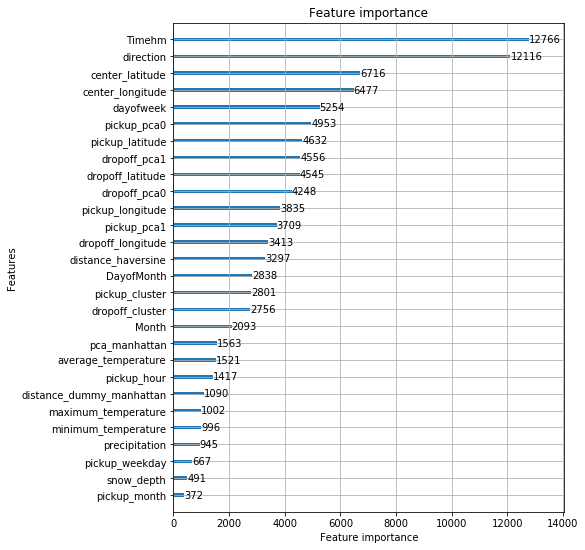

In [49]:
lgb.plot_importance(lgb_model,  max_num_features=28, figsize=(7,9))
plt.show()

In [50]:

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_logarithmic_error(y_true, y_pred))

In [51]:
pred = lgb_model.predict(test.drop(['eval_set','log_trip_duration'], axis=1).values, 
                         num_iteration = lgb_model.best_iteration)

In [53]:
pred1 = lgb_model.predict(X_train.values, num_iteration = lgb_model.best_iteration)
pred2 = lgb_model.predict(X_eval.values, num_iteration = lgb_model.best_iteration)
rmsle1= (((y_train-pred1)**2).mean())**0.5
rmsle2 = (((y_eval-pred2)**2).mean())**0.5
print('train score: {:.4f}   eval score: {:.4f}'.format(rmsle1,rmsle2))

train score: 0.2859   eval score: 0.2954
